## SISR - Single Image Super Resolution
## Machine Learning 6316
## Final Project
## Colin Price, Jacob Dineen, Kazi Ashik Islam, A S M Ahsan-Ul Haque 

### CODE ADAPTED FROM: https://github.com/krasserm/super-resolution


In [1]:
import os
import matplotlib.pyplot as plt

from data import DIV2K
from model.edsr import edsr
from train import EdsrTrainer,WdsrTrainer
import tensorflow as tf
from model.wdsr import wdsr_a, wdsr_b
%matplotlib inline
tf.__version__

'2.0.0'

### Load Data
#### Utilize Helper Functions 

Use only images w/ bicubic downsampling and X4 upscaling resolution.

·         800 low res images (train)

·         800 high res images (test)

·         100 low res images (validation)

·         100 low res images(validation)

train images go through a data augmentation pipeline (random flips/rotations/crops)


In [59]:
# Number of residual blocks
depth = [1,3,5,8]

# Super-resolution factor
scale = 4

# Downgrade operator
downgrade = 'bicubic'

div2k_train = DIV2K(scale=scale, subset='train', downgrade=downgrade)
div2k_valid = DIV2K(scale=scale, subset='valid', downgrade=downgrade)
'''
random transform: 
    pairwise (lr,hr)
        random_crop
        random_flip
        random_rotate
'''
train_ds = div2k_train.dataset(batch_size=16, random_transform=True)
valid_ds = div2k_valid.dataset(batch_size=1, random_transform=False, repeat_count=1)

### EDSR Train 

### Sample Model architecture - 1 Res Block
![alt text](notebookimages/model_edsr.png "Sample of Train vs Validation")

In [9]:
edsr_psnr = {}
for i in depth:
    '''Store Model Weights. Will have |depth| different folders = 4'''
    weights_dir = f'weights/edsr-{i}-x{scale}'
    weights_file = os.path.join(weights_dir, 'weights.h5')
    os.makedirs(weights_dir, exist_ok=True)

    
    '''instantiate training mechanism'''
    trainer = EdsrTrainer(model=edsr(scale=scale, num_res_blocks=i), 
                          checkpoint_dir=f'.ckpt/edsr-{i}-x{scale}')


    '''
    Train. 10k total steps. Evaluate, print PSNR and Val Loss (MAE) every 1000 steps
    Checkpoint best model.
    '''
    trainer.train(train_ds,
                  valid_ds.take(10),
                  steps=10000, 
                  evaluate_every=1000, 
                  save_best_only=True)

    '''Fetch Model From above'''
    trainer.restore()
    
    '''Store weights in weight directory'''
    trainer.model.save_weights(weights_file)
    
    '''Fetch total params - Can delete later'''
    model = edsr(scale=scale, num_res_blocks=i)
    model.load_weights(weights_file)
    print('model params:' , model.count_params())

    '''Get PSNR on full vali set'''
    psnrv = trainer.evaluate(valid_ds)
    print('Res_blocks: ', i, end = '')
    print(f'PSNR = {psnrv.numpy():3f}')
    edsr_psnr[i] = psnrv.numpy()

1000/10000: loss = 10.441, PSNR = 27.379795 (146.97s)
2000/10000: loss = 7.965, PSNR = 27.835556 (145.33s)
3000/10000: loss = 7.785, PSNR = 27.849218 (147.91s)
4000/10000: loss = 7.639, PSNR = 28.024607 (147.54s)
5000/10000: loss = 7.551, PSNR = 27.967762 (146.77s)
6000/10000: loss = 7.488, PSNR = 28.062775 (145.26s)
7000/10000: loss = 7.409, PSNR = 28.074310 (146.43s)
8000/10000: loss = 7.484, PSNR = 28.006409 (146.47s)
9000/10000: loss = 7.363, PSNR = 28.114590 (143.83s)
10000/10000: loss = 7.260, PSNR = 28.269867 (145.03s)
Model restored from checkpoint at step 10000.
model params: 409731
Res_blocks:  1PSNR = 27.490454
1000/10000: loss = 10.325, PSNR = 27.618481 (145.87s)
2000/10000: loss = 7.960, PSNR = 27.887335 (145.13s)
3000/10000: loss = 7.728, PSNR = 27.778173 (143.19s)
4000/10000: loss = 7.441, PSNR = 28.074860 (143.47s)
5000/10000: loss = 7.351, PSNR = 28.245869 (143.22s)
6000/10000: loss = 7.252, PSNR = 28.317890 (143.29s)
7000/10000: loss = 7.210, PSNR = 28.410812 (143.27s

### WDSRa Train

### Sample Model architecture - 1 Res Block
![alt text](notebookimages/model_wdsra.png "Sample of Train vs Validation")

In [10]:
wdsra_psnr = {}

for i in depth:
    '''Store Model Weights. Will have |depth| different folders = 4'''
    weights_dir = f'weights/wdsr-a-{i}-x{scale}'
    weights_file = os.path.join(weights_dir, 'weights.h5')
    os.makedirs(weights_dir, exist_ok=True)
    
    '''instantiate training mechanism'''
    trainer = WdsrTrainer(model=wdsr_a(scale=scale, num_res_blocks=i), 
                          checkpoint_dir=f'.ckpt/wdsr-a-{i}-x{scale}')
    '''
    Train. 10k total steps. Evaluate, print PSNR and Val Loss (MAE) every 1000 steps
    Checkpoint best model.
    '''
    trainer.train(train_ds,
                  valid_ds.take(10),
                  steps=10000, 
                  evaluate_every=1000, 
                  save_best_only=True)
    '''Fetch Model From above'''
    trainer.restore()
    
    '''Store weights in weight directory'''
    trainer.model.save_weights(weights_file)
    
    '''Fetch total params - Can delete later'''
    model = wdsr_a(scale=scale, num_res_blocks=i)
    model.load_weights(weights_file)
    print(model.count_params())
    
    '''Get PSNR on full vali set'''
    psnrv = trainer.evaluate(valid_ds)
    print('Res_blocks: ', i, end = '')
    print(f'PSNR = {psnrv.numpy():3f}')
    wdsra_psnr[i] = psnrv.numpy()

1000/10000: loss = 9.117, PSNR = 27.905094 (145.14s)
2000/10000: loss = 7.486, PSNR = 28.119501 (143.11s)
3000/10000: loss = 7.318, PSNR = 28.302311 (143.17s)
4000/10000: loss = 7.242, PSNR = 28.397131 (142.90s)
5000/10000: loss = 7.145, PSNR = 28.452698 (142.93s)
6000/10000: loss = 7.051, PSNR = 28.464966 (143.13s)
7000/10000: loss = 7.044, PSNR = 28.503626 (143.23s)
8000/10000: loss = 7.021, PSNR = 28.522064 (142.98s)
9000/10000: loss = 7.045, PSNR = 28.486691 (144.54s)
10000/10000: loss = 7.005, PSNR = 28.505829 (143.77s)
Model restored from checkpoint at step 8000.
92304
Res_blocks:  1PSNR = 27.775673
1000/10000: loss = 8.879, PSNR = 28.085764 (145.42s)
2000/10000: loss = 7.270, PSNR = 28.381586 (145.25s)
3000/10000: loss = 7.095, PSNR = 28.523138 (146.09s)
4000/10000: loss = 6.986, PSNR = 28.655045 (145.46s)
5000/10000: loss = 6.930, PSNR = 28.681839 (144.36s)
6000/10000: loss = 6.877, PSNR = 28.733444 (143.13s)
7000/10000: loss = 6.942, PSNR = 28.789499 (143.18s)
8000/10000: loss

### WDSRb Train


### Sample Model architecture - 1 Res Block
![alt text](notebookimages/model_wdsrb.png "Sample of Train vs Validation")

In [14]:
wdsrb_psnr = {}
for i in depth:
    '''Store Model Weights. Will have |depth| different folders = 4'''
    weights_dir = f'weights/wdsr-b-{i}-x{scale}'
    weights_file = os.path.join(weights_dir, 'weights.h5')

    os.makedirs(weights_dir, exist_ok=True)
    '''instantiate training mechanism'''

    trainer = WdsrTrainer(model=wdsr_b(scale=scale, num_res_blocks=i), 
                          checkpoint_dir=f'.ckpt/wdsr-b-{i}-x{scale}')
    '''
    Train. 10k total steps. Evaluate, print PSNR and Val Loss (MAE) every 1000 steps
    Checkpoint best model.
    '''
    trainer.train(train_ds,
                  valid_ds.take(10),
                  steps=10000, 
                  evaluate_every=1000, 
                  save_best_only=True)
    '''Fetch Model From above'''
    trainer.restore()
    
    '''Store weights in weight directory'''
    trainer.model.save_weights(weights_file)
    
    model = wdsr_b(scale=scale, num_res_blocks=i)
    model.load_weights(weights_file)

    print(model.count_params())
    
    '''Get PSNR on full vali set'''
    psnrv = trainer.evaluate(valid_ds)
    print('Res_blocks: ', i, end = '')
    print(f'PSNR = {psnrv.numpy():3f}')
    wdsrb_psnr[i] = psnrv.numpy()

Model restored from checkpoint at step 9000.
10000/10000: loss = 7.074, PSNR = 28.471064 (144.56s)
Model restored from checkpoint at step 10000.
36809
Res_blocks:  1PSNR = 27.716026
1000/10000: loss = 9.111, PSNR = 27.880213 (144.17s)
2000/10000: loss = 7.446, PSNR = 28.198948 (143.16s)
3000/10000: loss = 7.299, PSNR = 28.394812 (143.25s)
4000/10000: loss = 7.150, PSNR = 28.415119 (143.65s)
5000/10000: loss = 6.991, PSNR = 28.539316 (143.48s)
6000/10000: loss = 6.964, PSNR = 28.616053 (143.12s)
7000/10000: loss = 6.946, PSNR = 28.618103 (143.11s)
8000/10000: loss = 6.900, PSNR = 28.704885 (143.16s)
9000/10000: loss = 6.904, PSNR = 28.727594 (143.30s)
10000/10000: loss = 6.846, PSNR = 28.746363 (142.86s)
Model restored from checkpoint at step 10000.
73595
Res_blocks:  3PSNR = 28.033403
1000/10000: loss = 9.062, PSNR = 27.953938 (144.06s)
2000/10000: loss = 7.377, PSNR = 28.228378 (143.13s)
3000/10000: loss = 7.101, PSNR = 28.472651 (143.54s)
4000/10000: loss = 7.116, PSNR = 28.540564 (1

#### Our results
- Models likely trained far shorter (no reference in paper).
- WDSRa or WDSRb always outperform WDSR
- WDSRa and B always run at a fraction of the total number of params.
- WDSRb with 8 resblocks runs @ the highest Validation PSNR with 18% of the number of trainable parameters of EDSR.


![alt text](notebookimages/model_comp.png "Sample of Train vs Validation")

![alt text](notebookimages/8resblocks.png "Sample of Train vs Validation")

## Load Models


In [9]:
weights_file = f'weights/wdsr-b-{8}-x{4}/weights.h5'
weights_file
wdsrb = wdsr_b(scale=4, num_res_blocks=8)
wdsrb.load_weights(weights_file)
#model.summary()

#tf.keras.utils.plot_model(model, to_file='model_wdsrb.png')

weights_file = f'weights/wdsr-a-{8}-x{4}/weights.h5'
weights_file
wdsra = wdsr_a(scale=4, num_res_blocks=8)
wdsra.load_weights(weights_file)
#model.summary()

#tf.keras.utils.plot_model(model, to_file='model_wdsra.png')

weights_file = f'weights/edsr-{8}-x{4}/weights.h5'
weights_file
edsr1 = edsr(scale=4, num_res_blocks=8)
edsr1.load_weights(weights_file)
#model.summary()

#tf.keras.utils.plot_model(model, to_file='model_edsr.png')

In [54]:
from model import resolve_single
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
'''#rewrote to allow loop through all models.'''

def load_image(path):
    return np.array(Image.open(path))


def plot_sample(model, lr, sr):
    plt.figure(figsize=(20, 10))

    images = [lr, sr]
    titles = ['LR {}'.format, f'SR (x{sr.shape[0] // lr.shape[0]}) i']
    titles = ['LR {}'.format(model), 'SR x{} {}'.format(sr.shape[0] // lr.shape[0], model)]

    for i, (img, title) in enumerate(zip(images, titles)):
        plt.subplot(1, 2, i+1)
        plt.imshow(img)
        plt.title(title)
        plt.xticks([])
        plt.yticks([])
        
        
def resolve_and_plot(models, lr_image_path):
    lr = load_image(lr_image_path)
    print('\t \t \t \t Model Comparison using 8 Resblocks')
    for i,j in models.items():
        sr = resolve_single(j, lr)
        plot_sample(i, lr, sr)
        
models= {'WDSRa': wdsra, 'WDSRb': wdsrb, 'EDSR': edsr1}

	 	 	 	 Model Comparison using 8 Resblocks


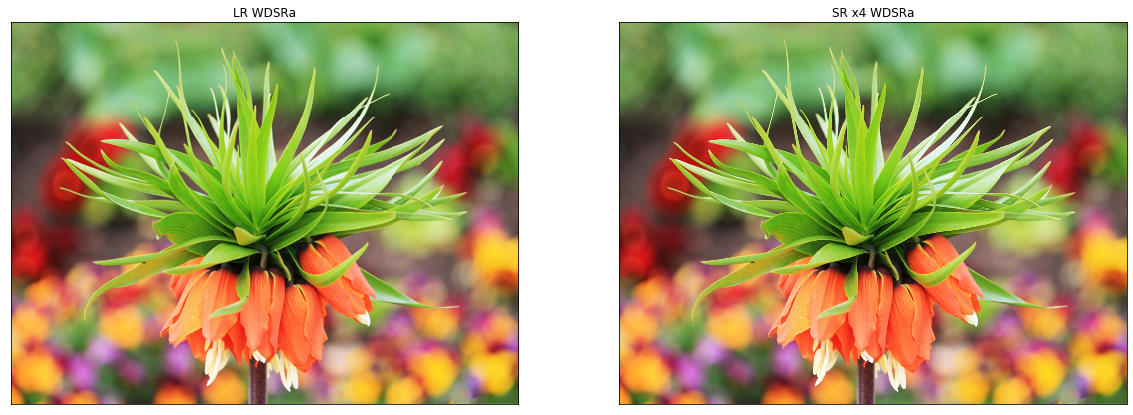

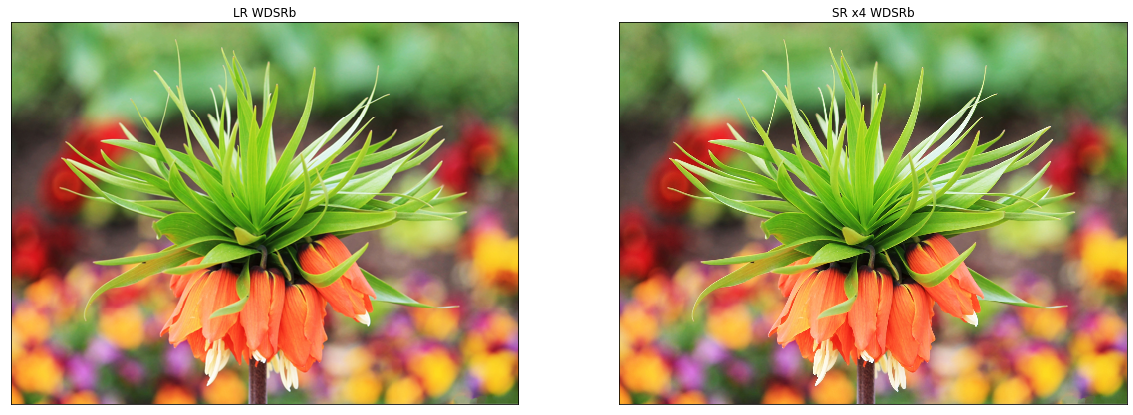

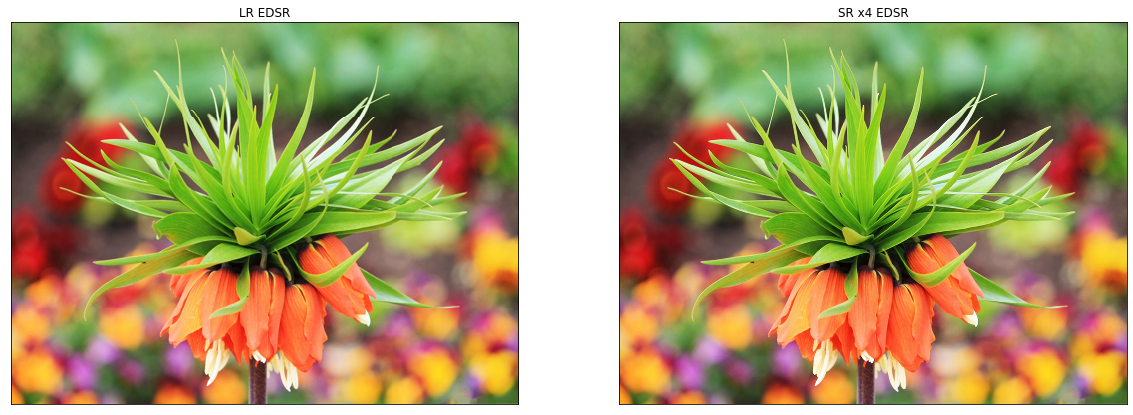

In [55]:
resolve_and_plot(models, 'demo/0803x4.png')


	 	 	 	 Model Comparison using 8 Resblocks


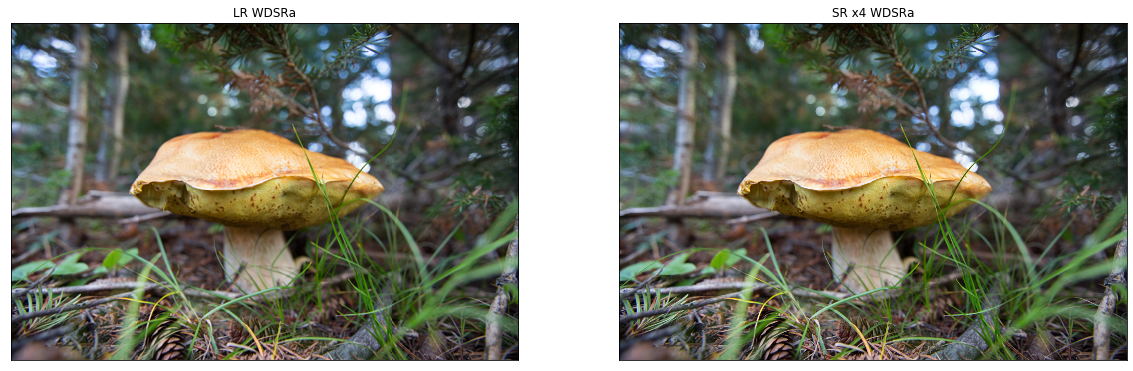

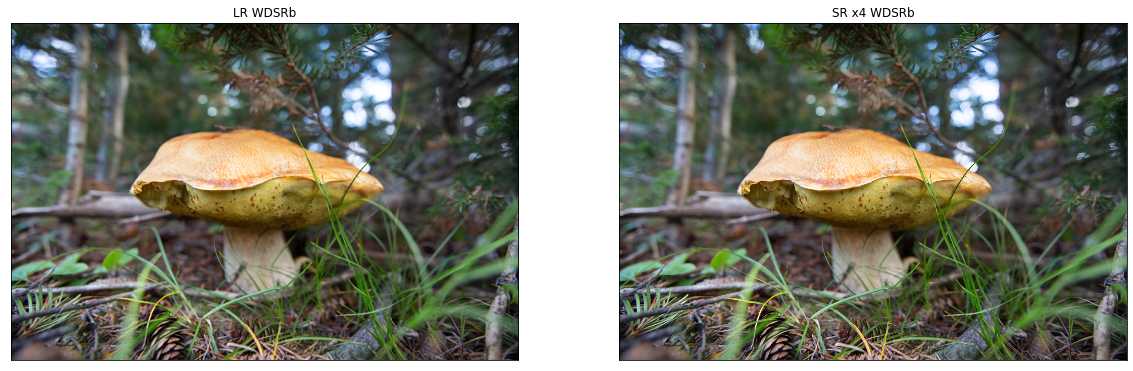

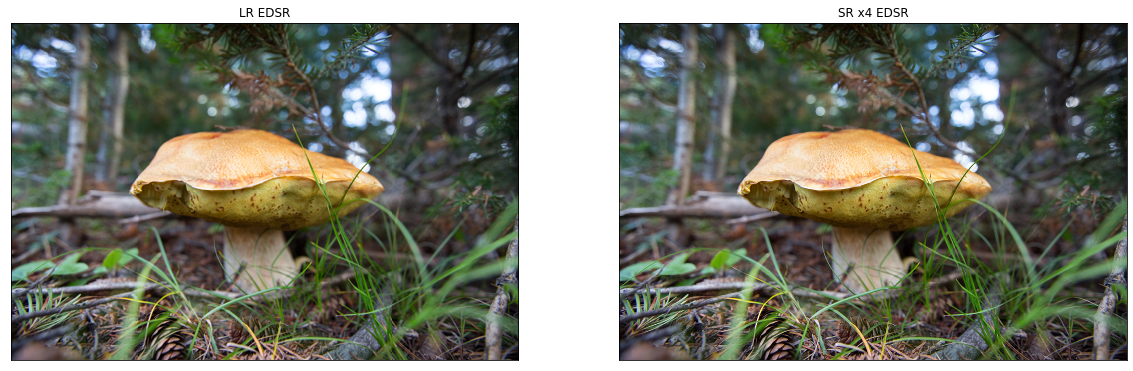

In [56]:
resolve_and_plot(models,'demo/0815x4.png')

	 	 	 	 Model Comparison using 8 Resblocks


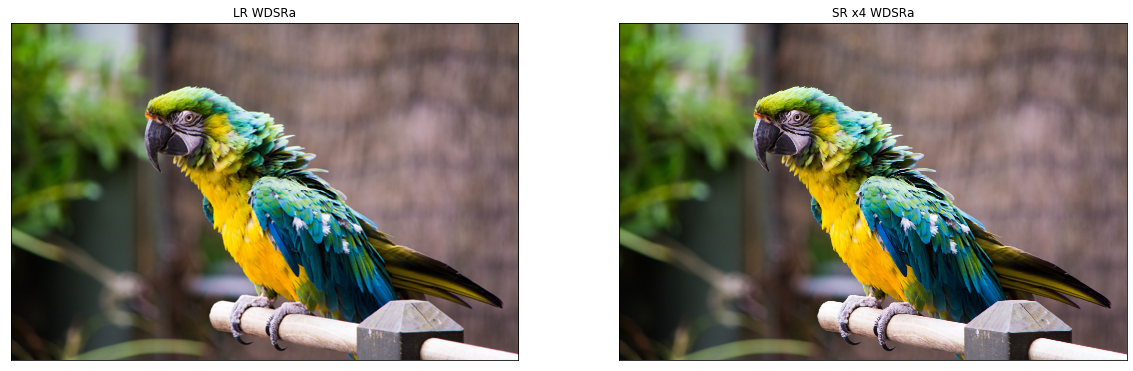

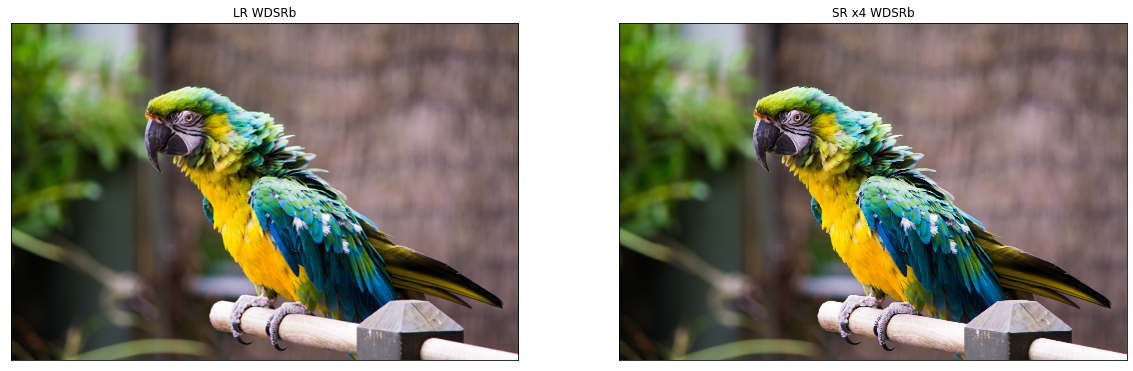

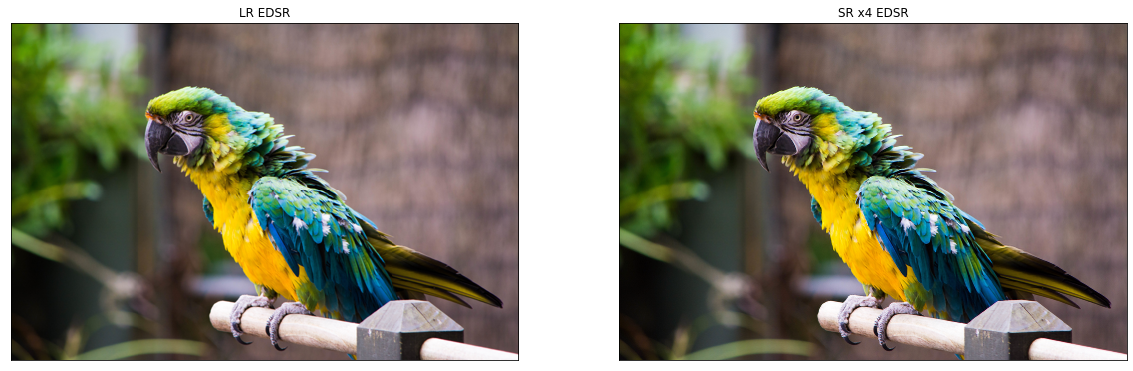

In [57]:
resolve_and_plot(models, 'demo/0886x4.png')